# Practice of Reinforcement Learning using Q learning implemented with Neural Networks

This notebook constitutes a practice of deep q learning inspired by https://www.youtube.com/watch?v=79pmNdyxEGo&t=1s&index=17&list=PL2-dafEMk2A7mu0bSksCGMJEmeddU_H4D. The objective is to train an agent to solve the Cart Pole OpenAI's control problem (https://github.com/openai/gym/wiki/CartPole-v0). It has been done with two types of agents. The firstone uses the raw pixel of the game besides a Convolutional Neural Network in order to balance the pole. The second approach uses a full conected Neural Netfork with just the information of the simulation provided by the OpenAI library in order to learn how to balance the pole

## Deep Q Learning implemented with Convolutional Neural Networks

In [1]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque
import random
import cv2
import scipy

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError




In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError


class DeepQNN:
    '''
    episodes - NUMBER OF GAMES
    gamma - discount rate
    epsilon - exploration rate
    epsilon_decay - decrease the number of explorations
    epsilon_min - lower epsilon
    lr - learning rate
    '''
    def __init__(self, env, path= 'deepqnn_model.ckpt', episodes = 1000 , gamma = 0.95, epsilon = 1, epsilon_decay=0.9, epsilon_min=0.05, lr=0.001, random_state=42):
    
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr
        self.random_state = random_state
        self.n_actions = env.action_space.n
        self.env = env
        self.batch_size = 75
        self.episodes = episodes
        self.model_params = None
        
        self.activation_fn = tf.nn.elu
        self.weights_initializer = tf.contrib.layers.variance_scaling_initializer()
        self.optimizer = tf.train.AdamOptimizer
        
        self._graph = None
        self._session = None
        self.training_op = None
        self.model = None
        self.init = None
        self.saver = None
        self.interactions = 500
        self.best_play = []
        self.path = path
        
        # Memory used for replaying actions
        '''
        using this memory improve stability. NN tends to forget previous actions learned, so the memory
        allows a esxperience replay
        '''
        self.memmory = deque()
        
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
            
        self.build_dnn()
        
        self.episodes_scores = []
            
    def build_dnn(self):
        #Reset Tensorflow Graph
        tf.reset_default_graph()
        tf.set_random_seed(self.random_state)
        np.random.seed(self.random_state)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            n_conv_filters = 32

            X = tf.placeholder(tf.float32, shape=(None, 160, 100, 1),name= 'state')
            y = tf.placeholder(tf.float32, shape=(None), name='quality')
            self._X, self._y = X, y
            self.training = tf.placeholder_with_default(False, shape=[], name='training')

            conv_one = tf.layers.conv2d(X,filters= 4, kernel_size=2, strides=1,
                                    padding= "SAME", name="conv1"
                                   ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            
            #conv_one = tf.layers.batch_normalization(conv_one, training=self.training, momentum=0.9)
            #conv_one = tf.nn.relu(conv_one)
            
            conv_two = tf.layers.conv2d(conv_one, filters= 3, kernel_size=4, strides=1,
                                    padding= "SAME", name="conv2"
                                   ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            
            #conv_two = tf.layers.batch_normalization(conv_two, training=self.training, momentum=0.9)
            #conv_two = tf.nn.relu(conv_two)
            
            conv_three = tf.layers.conv2d(conv_two ,filters= 2, kernel_size=4, strides=1,
                                    padding= "SAME", name="conv3"
                                   ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            
            #conv_three = tf.layers.batch_normalization(conv_three, training=self.training, momentum=0.9)
            #conv_three = tf.nn.relu(conv_three)
            
            
            conv_four = tf.layers.conv2d(conv_three ,filters= 2, kernel_size=4, strides=1,
                                    padding= "SAME", name="conv4"
                                   ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            
            #conv_four = tf.layers.batch_normalization(conv_four, training=self.training, momentum=0.9)
            #conv_four = tf.nn.relu(conv_four)
            
            conv_five = tf.layers.conv2d(conv_four, filters= 2, kernel_size=4, strides=1,
                                   padding= "SAME", name="conv5"
                                  ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            
            #conv_five = tf.layers.batch_normalization(conv_five, training=self.training, momentum=0.9)
            #conv_five = tf.nn.relu(conv_five)
            
            conv_six = tf.layers.conv2d(conv_four, filters= 2, kernel_size=4, strides=1,
                                   padding= "SAME", name="conv6"
                                  ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            
            #conv_six = tf.layers.batch_normalization(conv_six, training=self.training, momentum=0.9)
            #conv_six = tf.nn.relu(conv_six)
            
            flat = tf.reshape(conv_six , shape=[-1, 2 * 160 * 100])
            #with tf.name_scope("pool"):
            #    pool = tf.nn.max_pool(conv_two, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            #   pool_flat = tf.reshape(pool, shape=[-1, n_conv_filters * 32 * 32])

            with tf.name_scope("fc"):
                fc1 = tf.layers.dense(flat, 12, name="fc1"
                                      , kernel_initializer = tf.contrib.layers.xavier_initializer())
                #fc1 = tf.layers.batch_normalization(fc1, training=self.training, momentum=0.9)
                #fc1 = tf.nn.elu(fc1)
            
                fc1 = tf.layers.dropout(fc1, 0.5, training = self.training)
                
                fc2 = tf.layers.dense(fc1, 12, activation=tf.nn.elu,name="fc2"
                                      ,kernel_initializer = tf.contrib.layers.xavier_initializer())
                #fc2 = tf.layers.batch_normalization(fc2, training=self.training, momentum=0.9)
                #fc2 = tf.nn.elu(fc2)
            
                fc2 = tf.layers.dropout(fc2, 0.5, training = self.training)
                
                #fc3 = tf.layers.dense(fc2, 12, activation=tf.nn.elu,name="fc3"
                #                      ,kernel_initializer = tf.contrib.layers.xavier_initializer())
                #fc3 = tf.layers.batch_normalization(fc3, training=self.training, momentum=0.9)
                #fc3 = tf.nn.elu(fc3)
                #fc3 = tf.layers.dropout(fc3, 0.5, training = self.training)
                # Dense with linear activation function
                self.model = tf.layers.dense(fc2, self.n_actions,name="output"
                                            ,kernel_initializer = tf.contrib.layers.xavier_initializer())

            with tf.name_scope("train"):
                loss = tf.losses.huber_loss(self._y, self.model)
                optimizer = tf.train.RMSPropOptimizer(self.lr,decay=0.95)
                self.training_op = optimizer.minimize(loss, name = "training")

            with tf.name_scope("init_and_save"):
                self.init = tf.global_variables_initializer()
                self.saver = tf.train.Saver()
            
        self._session = tf.Session(graph=self._graph)
       
            
    def remember_transition(self,state, action, reward, new_state, end):
        
        self.memmory.append((state, action, reward, new_state, end))
        
    def minibatch_sample(self):
        return random.sample(self.memmory, self.batch_size)
    
    def predict(self,state):
        with self._session.as_default() as sess:
            return self.model.eval(feed_dict={self._X: state, self.training:False})
    
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        predict = self.predict(state)[0]
        return np.argmax(predict)

    def experience_learing(self):

        minibatch = random.sample(self.memmory, self.batch_size)
        for state, action, reward, next_state, end in minibatch:
            target = reward
            if not end:
                target = reward + self.gamma * np.amax(self.predict(next_state)[0])
            target_f = self.predict(state)[0]
            target_f[action] = target         

            with self._session.as_default() as sess:
                sess.run(self.training_op, feed_dict={self._X: state, self._y: target_f, self.training: True})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
       
    def combine(self, current_frame, new_frame, pos):
        
        current_frame = cv2.cvtColor(np.asarray(current_frame), cv2.COLOR_BGR2GRAY)
        #current_frame =  current_frame.reshape(current_frame.shape[0],current_frame.shape[1],1)
        new_frame = cv2.cvtColor(np.asarray(new_frame), cv2.COLOR_BGR2GRAY)
        #new_frame = new_frame.reshape(new_frame.shape[0],new_frame.shape[1],1)
        
        #comb = np.concatenate((new_frame, current_frame), axis=2)
        comb = new_frame - current_frame 
        
        pos = self.position(pos)
        min_pos = pos - 50
        max_pos = pos +50
        if min_pos < 0:
            min_pos = 0
            max_pos = 100
        if max_pos > 600:
            min_pos = 500
            max_pos = 600
        
        comb = comb[160:320,min_pos:max_pos]
        #comb = cv2.resize(comb,(64,64))
        #_, comb[:,:,0] = cv2.threshold(comb[:,:,0],200,255,cv2.THRESH_BINARY)
        #_, comb[:,:,1] = cv2.threshold(comb[:,:,1],200,255,cv2.THRESH_BINARY)

        return comb.reshape(1,160,100,1)
        
        
    def diff_frames(self, current, past):        
        diff = cv2.cvtColor(np.asarray(current-past), cv2.COLOR_BGR2GRAY)
        return diff
    
    def position(self,pos):
        screen_width = 600
        world_width = 2.4* 2
        scale = screen_width / world_width
        pos = int(pos * scale + screen_width / 2.0)
        return pos
        
    def state_transformation(self, pos, img):
        img = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
        pos = self.position(pos)
        min_pos = pos - 50
        max_pos = pos +50
        if min_pos < 0:
            min_pos = 0
            max_pos = 100
        if max_pos > 600:
            min_pos = 500
            max_pos = 600
       
        img = img[160:320,min_pos:max_pos]
        #img = cv2.resize(img,(64,64))
        _, img = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
        return img.reshape(1,160,100,1)
        
    
    def get_model_params(self):
        gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

    def restore_model_params(self, model_params):
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        tf.get_default_session().run(assign_ops, feed_dict=feed_dict)
    
    def calculate_reward(self, reward, obs, end):
        if end:
            return 0
        return reward + pow(1.25,1.0/abs(obs[2])) + (pow(1.25, 1.0/abs(obs[3]))) *0.8 + (pow(1.25,1.0/abs(obs[1])))* 0.8
        
    def run_network(self, train = True, ep = None):
        if ep is None:
            ep = self.episodes
        self.episodes_scores = []
        state_size = self.env.observation_space.shape[0]
        with self._session.as_default() as sess:
            self.init.run()
        end = False
        max_iterations = 0
        for e in range(ep):
            obs = self.env.reset()
            state = self.env.render(mode='rgb_array')
            self.best_play.append(state)
            next_state = self.env.render(mode='rgb_array') 
            comb = self.combine(state, next_state, obs[0])
            
            for iteration in range(self.interactions):
                action = self.select_action(comb)  
                obs, reward, end, _ = env.step(action)
                next_state  = self.env.render(mode='rgb_array')
                self.best_play.append(next_state)
                next_comb = self.combine(state, next_state, obs[0])
                #next_state = self.state_transformation(obs[0],next_state)
                reward = self.calculate_reward(reward,obs,end)
                self.remember_transition(comb, action, reward, next_comb, end)
                state = next_state
                comb = next_comb
                if end:
                    self.episodes_scores.append(iteration)
                    print("Episode: %d/%d, score: %d" % (e, ep, iteration))
                    if iteration > max_iterations:
                        max_iterations = iteration 
                    else:
                        self.best_play = []
                    break

            if train and len(self.memmory) > self.batch_size:
                self.experience_learing()
    

        print("Best Number of Iterations: %d" % (max_iterations))
        
        if train:
            with self._session.as_default() as sess:
                self.saver.save(sess, self.path)  

    def train(self):
        self.run_network(True)
        
    def play(self, ep = 100):
        self.run_network(False, ep = ep)
        
    def restore_model(self, path_model = None):
        if not path_model:
            self.path = path_model
        with self._session.as_default() as sess:
            self.saver.restore(sess, self.path)
        
    def plot_training_scores(self):
        if len(self.episodes_scores) > 0:
            plt.figure()
            plt.plot(range(len(self.episodes_scores)), self.episodes_scores)
            plt.show()
        


In [3]:
env = gym.make('CartPole-v1')
q_dnn= DeepQNN(env)

[2017-09-18 10:11:20,662] Making new env: CartPole-v1


In [4]:
q_dnn.train()

Episode: 0/1000, score: 18
Episode: 1/1000, score: 17
Episode: 2/1000, score: 10
Episode: 3/1000, score: 34
Episode: 4/1000, score: 19
Episode: 5/1000, score: 29
Episode: 6/1000, score: 11
Episode: 7/1000, score: 25
Episode: 8/1000, score: 27
Episode: 9/1000, score: 10
Episode: 10/1000, score: 11
Episode: 11/1000, score: 14
Episode: 12/1000, score: 14
Episode: 13/1000, score: 11
Episode: 14/1000, score: 10
Episode: 15/1000, score: 12
Episode: 16/1000, score: 10
Episode: 17/1000, score: 15
Episode: 18/1000, score: 16
Episode: 19/1000, score: 14
Episode: 20/1000, score: 13
Episode: 21/1000, score: 15
Episode: 22/1000, score: 16
Episode: 23/1000, score: 18
Episode: 24/1000, score: 21
Episode: 25/1000, score: 16
Episode: 26/1000, score: 15
Episode: 27/1000, score: 8
Episode: 28/1000, score: 15


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:260: RuntimeWarning: overflow encountered in double_scalars


Episode: 29/1000, score: 17
Episode: 30/1000, score: 27
Episode: 31/1000, score: 12
Episode: 32/1000, score: 10
Episode: 33/1000, score: 39
Episode: 34/1000, score: 31
Episode: 35/1000, score: 23
Episode: 36/1000, score: 35
Episode: 37/1000, score: 45
Episode: 38/1000, score: 35
Episode: 39/1000, score: 57
Episode: 40/1000, score: 123
Episode: 41/1000, score: 21
Episode: 42/1000, score: 69
Episode: 43/1000, score: 39
Episode: 44/1000, score: 112
Episode: 45/1000, score: 42
Episode: 46/1000, score: 60
Episode: 47/1000, score: 137
Episode: 48/1000, score: 59
Episode: 49/1000, score: 17
Episode: 50/1000, score: 33
Episode: 51/1000, score: 14
Episode: 52/1000, score: 95
Episode: 53/1000, score: 13
Episode: 54/1000, score: 67
Episode: 55/1000, score: 65
Episode: 56/1000, score: 42
Episode: 57/1000, score: 12
Episode: 58/1000, score: 32
Episode: 59/1000, score: 67
Episode: 60/1000, score: 31
Episode: 61/1000, score: 41
Episode: 62/1000, score: 70
Episode: 63/1000, score: 16
Episode: 64/1000,

Episode: 308/1000, score: 128
Episode: 309/1000, score: 219
Episode: 310/1000, score: 176
Episode: 311/1000, score: 167
Episode: 312/1000, score: 211
Episode: 313/1000, score: 225
Episode: 314/1000, score: 189
Episode: 315/1000, score: 183
Episode: 316/1000, score: 161
Episode: 317/1000, score: 182
Episode: 318/1000, score: 209
Episode: 319/1000, score: 201
Episode: 320/1000, score: 159
Episode: 321/1000, score: 190
Episode: 322/1000, score: 119
Episode: 323/1000, score: 198
Episode: 324/1000, score: 168
Episode: 325/1000, score: 168
Episode: 326/1000, score: 170
Episode: 327/1000, score: 166
Episode: 328/1000, score: 150
Episode: 329/1000, score: 174
Episode: 330/1000, score: 203
Episode: 331/1000, score: 176
Episode: 332/1000, score: 176
Episode: 333/1000, score: 151
Episode: 334/1000, score: 199
Episode: 335/1000, score: 207
Episode: 336/1000, score: 138
Episode: 337/1000, score: 191
Episode: 338/1000, score: 169
Episode: 339/1000, score: 204
Episode: 340/1000, score: 201
Episode: 3

Episode: 582/1000, score: 121
Episode: 583/1000, score: 135
Episode: 584/1000, score: 237
Episode: 585/1000, score: 208
Episode: 586/1000, score: 142
Episode: 587/1000, score: 198
Episode: 588/1000, score: 167
Episode: 589/1000, score: 191
Episode: 590/1000, score: 192
Episode: 591/1000, score: 159
Episode: 592/1000, score: 194
Episode: 593/1000, score: 186
Episode: 594/1000, score: 187
Episode: 595/1000, score: 239
Episode: 596/1000, score: 194
Episode: 597/1000, score: 183
Episode: 598/1000, score: 169
Episode: 599/1000, score: 108
Episode: 600/1000, score: 202
Episode: 601/1000, score: 164
Episode: 602/1000, score: 229
Episode: 603/1000, score: 227
Episode: 604/1000, score: 166
Episode: 605/1000, score: 170
Episode: 606/1000, score: 189
Episode: 607/1000, score: 167
Episode: 608/1000, score: 156
Episode: 609/1000, score: 163
Episode: 610/1000, score: 172
Episode: 611/1000, score: 105
Episode: 612/1000, score: 168
Episode: 613/1000, score: 216
Episode: 614/1000, score: 233
Episode: 6

Episode: 856/1000, score: 159
Episode: 857/1000, score: 169
Episode: 858/1000, score: 172
Episode: 859/1000, score: 172
Episode: 860/1000, score: 203
Episode: 861/1000, score: 179
Episode: 862/1000, score: 228
Episode: 863/1000, score: 189
Episode: 864/1000, score: 192
Episode: 865/1000, score: 169
Episode: 866/1000, score: 188
Episode: 867/1000, score: 210
Episode: 868/1000, score: 161
Episode: 869/1000, score: 189
Episode: 870/1000, score: 161
Episode: 871/1000, score: 196
Episode: 872/1000, score: 208
Episode: 873/1000, score: 188
Episode: 874/1000, score: 189
Episode: 875/1000, score: 191
Episode: 876/1000, score: 209
Episode: 877/1000, score: 215
Episode: 878/1000, score: 165
Episode: 879/1000, score: 229
Episode: 880/1000, score: 83
Episode: 881/1000, score: 195
Episode: 882/1000, score: 190
Episode: 883/1000, score: 164
Episode: 884/1000, score: 174
Episode: 885/1000, score: 187
Episode: 886/1000, score: 205
Episode: 887/1000, score: 13
Episode: 888/1000, score: 202
Episode: 889

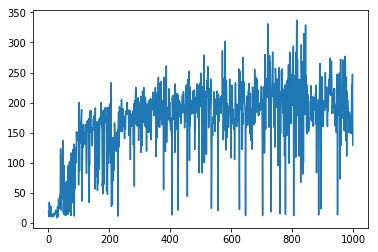

In [5]:
q_dnn.plot_training_scores()

## Deep Q Learning implemented with Full Conected Neural Networks

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError



class QNN:
    '''
    episodes - NUMBER OF GAMES
    gamma - discount rate
    epsilon - exploration rate
    epsilon_decay - decrease the number of explorations
    epsilon_min - lower epsilon
    lr - learning rate
    '''
    def __init__(self, env, episodes = 2000 , gamma = 0.95, epsilon = 1, epsilon_decay=0.995, epsilon_min=0.05, lr=0.001, random_state=42):
    
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr
        self.random_state = random_state
        self.n_actions = env.action_space.n
        self.env = env
        self.batch_size = 50
        self.episodes = episodes
        self.model_params = None
        
        self.activation_fn = tf.nn.elu
        self.weights_initializer = tf.contrib.layers.variance_scaling_initializer()
        self.optimizer = tf.train.AdamOptimizer
        
        self._graph = None
        self._session = None
        self.training_op = None
        self.model = None
        self.init = None
        self.saver = None
        
        # Memory used for replaying actions
        '''
        using this memory improve stability. NN tends to forget previous actions learned, so the memory
        allows a esxperience replay
        '''
        self.memmory = deque()
        
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
            
        self.build_dnn()
            
    def build_dnn(self):
        #Reset Tensorflow Graph
        tf.reset_default_graph()
        tf.set_random_seed(self.random_state)
        np.random.seed(self.random_state)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            X = tf.placeholder(tf.float32, shape=(None,4),name= 'state')
            y = tf.placeholder(tf.float32, shape=(None), name='quality')
            self._X, self._y = X, y
            self.training = tf.placeholder_with_default(False, shape=[], name='training')

            with tf.name_scope("fc"):
                fc1 = tf.layers.dense(X, 12, activation=tf.nn.relu, name="fc1")
                #fc1_dropout = tf.layers.dropout(fc1, 0.5, training = self.training)
                fc2 = tf.layers.dense(fc1, 12, activation=tf.nn.relu,name="fc2")
                #fc2_dropout = tf.layers.dropout(fc2, 0.5, training = self.training)
                # Dense with linear activation function
                self.model = tf.layers.dense(fc2, self.n_actions,name="fc3")

            with tf.name_scope("train"):
                loss = tf.losses.mean_squared_error(self._y, self.model)
                optimizer = tf.train.AdamOptimizer(0.001)
                self.training_op = optimizer.minimize(loss, name = "training")

            with tf.name_scope("init_and_save"):
                self.init = tf.global_variables_initializer()
                self.saver = tf.train.Saver()
            
        self._session = tf.Session(graph=self._graph)
       
            
    def remember_transition(self,state, action, reward, new_state, end):
        
        self.memmory.append((state, action, reward, new_state, end))
        
    def minibatch_sample(self):
        return random.sample(self.memmory, self.batch_size)
    
    def predict(self,state):
        with self._session.as_default() as sess:
            return self.model.eval(feed_dict={self._X: state.reshape(1,4), self.training:False})
    
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        predict = self.predict(state)[0]
        #print('Action ',predict)
        #print('Predicted ',np.argmax(predict))
        return np.argmax(predict)

    def experience_learing(self):
        
        minibatch = random.sample(self.memmory, self.batch_size)
        for state, action, reward, next_state, end in minibatch:
            target = reward
            if not end:
                target = reward + self.gamma * np.amax(self.predict(next_state)[0])
            target_f = self.predict(state)[0]
            target_f[action] = target         

            with self._session.as_default() as sess:
                sess.run(self.training_op, feed_dict={self._X: state.reshape(1,4), self._y: target_f, self.training: True})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        '''
        states = self.minibatch_sample()
        inputs = np.zeros((self.batch_size,4))
        targets = np.zeros((self.batch_size, self.n_actions))
        for i in range(len(states)):
            state = states[i][0]
            action = states[i][1] 
            reward = states[i][2]
            new_state = states[i][3]
            end = states[i][4]
            # Bellman equation
            inputs[i] = state
            quality = reward + self.gamma * np.amax(self.predict(new_state)[0])
            if end:
                quality = reward
            targets[i] = self.predict(state)
            targets[i][action] = quality
            
        with self._session.as_default() as sess:
            sess.run(self.training_op, feed_dict={self._X: inputs, self._y: targets, self.training: True})
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        '''        
        
         

    
    def get_model_params(self):
        gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

    def restore_model_params(self, model_params):
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

    
    def train(self):
        interactions = 2000
        state_size = self.env.observation_space.shape[0]
        with self._session.as_default() as sess:
            self.init.run()
        end = False
        max_iterations = 0
        for e in range(self.episodes):
            state = self.env.reset().reshape(1, self.env.observation_space.shape[0])
             
            for iteration in range(interactions):
                action = self.select_action(state) 
                next_state, reward, end, _ = env.step(action)
                #extra_reward = 1.0/abs(next_state[2]) + 1.0/abs(next_state[3])
                reward = reward #+ extra_reward
                self.remember_transition(state, action, reward, next_state, end)
                state = next_state 
                if end:
                    print("Episode: %d/%d, score: %d" % (e, self.episodes, iteration))
                    if iteration > max_iterations:
                        max_iterations = iteration 
                    break

            if len(self.memmory) > self.batch_size:
                self.experience_learing()
    

        print("Best Number of Iterations: %d" % (max_iterations))
        
        with self._session.as_default() as sess:
            self.saver.save(sess, "./openai_nn.ckpt")  
            
    

In [7]:
env = gym.make('CartPole-v1')
q_dnn= QNN(env)
q_dnn.train()

[2017-09-18 12:23:49,261] Making new env: CartPole-v1


Episode: 0/2000, score: 21
Episode: 1/2000, score: 8
Episode: 2/2000, score: 15
Episode: 3/2000, score: 15
Episode: 4/2000, score: 18
Episode: 5/2000, score: 10
Episode: 6/2000, score: 15
Episode: 7/2000, score: 23
Episode: 8/2000, score: 8
Episode: 9/2000, score: 14
Episode: 10/2000, score: 11
Episode: 11/2000, score: 19
Episode: 12/2000, score: 21
Episode: 13/2000, score: 14
Episode: 14/2000, score: 17
Episode: 15/2000, score: 12
Episode: 16/2000, score: 11
Episode: 17/2000, score: 12
Episode: 18/2000, score: 27
Episode: 19/2000, score: 39
Episode: 20/2000, score: 10
Episode: 21/2000, score: 17
Episode: 22/2000, score: 32
Episode: 23/2000, score: 31
Episode: 24/2000, score: 59
Episode: 25/2000, score: 21
Episode: 26/2000, score: 18
Episode: 27/2000, score: 19
Episode: 28/2000, score: 17
Episode: 29/2000, score: 32
Episode: 30/2000, score: 17
Episode: 31/2000, score: 22
Episode: 32/2000, score: 18
Episode: 33/2000, score: 22
Episode: 34/2000, score: 13
Episode: 35/2000, score: 42
Epis

Episode: 288/2000, score: 94
Episode: 289/2000, score: 116
Episode: 290/2000, score: 64
Episode: 291/2000, score: 142
Episode: 292/2000, score: 68
Episode: 293/2000, score: 76
Episode: 294/2000, score: 56
Episode: 295/2000, score: 33
Episode: 296/2000, score: 55
Episode: 297/2000, score: 48
Episode: 298/2000, score: 60
Episode: 299/2000, score: 81
Episode: 300/2000, score: 94
Episode: 301/2000, score: 49
Episode: 302/2000, score: 56
Episode: 303/2000, score: 60
Episode: 304/2000, score: 58
Episode: 305/2000, score: 28
Episode: 306/2000, score: 22
Episode: 307/2000, score: 17
Episode: 308/2000, score: 41
Episode: 309/2000, score: 59
Episode: 310/2000, score: 30
Episode: 311/2000, score: 61
Episode: 312/2000, score: 23
Episode: 313/2000, score: 45
Episode: 314/2000, score: 165
Episode: 315/2000, score: 28
Episode: 316/2000, score: 55
Episode: 317/2000, score: 77
Episode: 318/2000, score: 55
Episode: 319/2000, score: 59
Episode: 320/2000, score: 63
Episode: 321/2000, score: 79
Episode: 32

Episode: 570/2000, score: 198
Episode: 571/2000, score: 212
Episode: 572/2000, score: 65
Episode: 573/2000, score: 92
Episode: 574/2000, score: 23
Episode: 575/2000, score: 28
Episode: 576/2000, score: 92
Episode: 577/2000, score: 96
Episode: 578/2000, score: 433
Episode: 579/2000, score: 74
Episode: 580/2000, score: 112
Episode: 581/2000, score: 76
Episode: 582/2000, score: 47
Episode: 583/2000, score: 38
Episode: 584/2000, score: 128
Episode: 585/2000, score: 44
Episode: 586/2000, score: 75
Episode: 587/2000, score: 55
Episode: 588/2000, score: 187
Episode: 589/2000, score: 139
Episode: 590/2000, score: 152
Episode: 591/2000, score: 192
Episode: 592/2000, score: 63
Episode: 593/2000, score: 171
Episode: 594/2000, score: 261
Episode: 595/2000, score: 319
Episode: 596/2000, score: 58
Episode: 597/2000, score: 98
Episode: 598/2000, score: 67
Episode: 599/2000, score: 85
Episode: 600/2000, score: 116
Episode: 601/2000, score: 93
Episode: 602/2000, score: 76
Episode: 603/2000, score: 111


Episode: 847/2000, score: 499
Episode: 848/2000, score: 492
Episode: 849/2000, score: 499
Episode: 850/2000, score: 262
Episode: 851/2000, score: 393
Episode: 852/2000, score: 420
Episode: 853/2000, score: 316
Episode: 854/2000, score: 349
Episode: 855/2000, score: 228
Episode: 856/2000, score: 499
Episode: 857/2000, score: 499
Episode: 858/2000, score: 361
Episode: 859/2000, score: 499
Episode: 860/2000, score: 219
Episode: 861/2000, score: 213
Episode: 862/2000, score: 328
Episode: 863/2000, score: 378
Episode: 864/2000, score: 433
Episode: 865/2000, score: 285
Episode: 866/2000, score: 240
Episode: 867/2000, score: 293
Episode: 868/2000, score: 273
Episode: 869/2000, score: 216
Episode: 870/2000, score: 254
Episode: 871/2000, score: 187
Episode: 872/2000, score: 216
Episode: 873/2000, score: 231
Episode: 874/2000, score: 250
Episode: 875/2000, score: 294
Episode: 876/2000, score: 279
Episode: 877/2000, score: 264
Episode: 878/2000, score: 255
Episode: 879/2000, score: 351
Episode: 8

Episode: 1118/2000, score: 485
Episode: 1119/2000, score: 362
Episode: 1120/2000, score: 261
Episode: 1121/2000, score: 286
Episode: 1122/2000, score: 353
Episode: 1123/2000, score: 499
Episode: 1124/2000, score: 297
Episode: 1125/2000, score: 478
Episode: 1126/2000, score: 499
Episode: 1127/2000, score: 240
Episode: 1128/2000, score: 499
Episode: 1129/2000, score: 260
Episode: 1130/2000, score: 383
Episode: 1131/2000, score: 257
Episode: 1132/2000, score: 420
Episode: 1133/2000, score: 348
Episode: 1134/2000, score: 314
Episode: 1135/2000, score: 367
Episode: 1136/2000, score: 188
Episode: 1137/2000, score: 269
Episode: 1138/2000, score: 234
Episode: 1139/2000, score: 219
Episode: 1140/2000, score: 270
Episode: 1141/2000, score: 332
Episode: 1142/2000, score: 219
Episode: 1143/2000, score: 255
Episode: 1144/2000, score: 160
Episode: 1145/2000, score: 153
Episode: 1146/2000, score: 181
Episode: 1147/2000, score: 199
Episode: 1148/2000, score: 159
Episode: 1149/2000, score: 135
Episode:

Episode: 1384/2000, score: 177
Episode: 1385/2000, score: 310
Episode: 1386/2000, score: 494
Episode: 1387/2000, score: 215
Episode: 1388/2000, score: 435
Episode: 1389/2000, score: 183
Episode: 1390/2000, score: 179
Episode: 1391/2000, score: 161
Episode: 1392/2000, score: 197
Episode: 1393/2000, score: 193
Episode: 1394/2000, score: 317
Episode: 1395/2000, score: 205
Episode: 1396/2000, score: 189
Episode: 1397/2000, score: 432
Episode: 1398/2000, score: 499
Episode: 1399/2000, score: 306
Episode: 1400/2000, score: 379
Episode: 1401/2000, score: 499
Episode: 1402/2000, score: 439
Episode: 1403/2000, score: 255
Episode: 1404/2000, score: 332
Episode: 1405/2000, score: 328
Episode: 1406/2000, score: 292
Episode: 1407/2000, score: 252
Episode: 1408/2000, score: 271
Episode: 1409/2000, score: 232
Episode: 1410/2000, score: 223
Episode: 1411/2000, score: 499
Episode: 1412/2000, score: 449
Episode: 1413/2000, score: 227
Episode: 1414/2000, score: 474
Episode: 1415/2000, score: 434
Episode:

Episode: 1649/2000, score: 259
Episode: 1650/2000, score: 302
Episode: 1651/2000, score: 279
Episode: 1652/2000, score: 363
Episode: 1653/2000, score: 269
Episode: 1654/2000, score: 365
Episode: 1655/2000, score: 499
Episode: 1656/2000, score: 256
Episode: 1657/2000, score: 499
Episode: 1658/2000, score: 321
Episode: 1659/2000, score: 236
Episode: 1660/2000, score: 335
Episode: 1661/2000, score: 187
Episode: 1662/2000, score: 170
Episode: 1663/2000, score: 190
Episode: 1664/2000, score: 189
Episode: 1665/2000, score: 159
Episode: 1666/2000, score: 158
Episode: 1667/2000, score: 172
Episode: 1668/2000, score: 167
Episode: 1669/2000, score: 167
Episode: 1670/2000, score: 499
Episode: 1671/2000, score: 297
Episode: 1672/2000, score: 362
Episode: 1673/2000, score: 373
Episode: 1674/2000, score: 378
Episode: 1675/2000, score: 275
Episode: 1676/2000, score: 401
Episode: 1677/2000, score: 309
Episode: 1678/2000, score: 186
Episode: 1679/2000, score: 290
Episode: 1680/2000, score: 239
Episode:

Episode: 1915/2000, score: 206
Episode: 1916/2000, score: 256
Episode: 1917/2000, score: 499
Episode: 1918/2000, score: 156
Episode: 1919/2000, score: 257
Episode: 1920/2000, score: 467
Episode: 1921/2000, score: 499
Episode: 1922/2000, score: 373
Episode: 1923/2000, score: 205
Episode: 1924/2000, score: 499
Episode: 1925/2000, score: 302
Episode: 1926/2000, score: 345
Episode: 1927/2000, score: 499
Episode: 1928/2000, score: 353
Episode: 1929/2000, score: 428
Episode: 1930/2000, score: 244
Episode: 1931/2000, score: 216
Episode: 1932/2000, score: 339
Episode: 1933/2000, score: 264
Episode: 1934/2000, score: 212
Episode: 1935/2000, score: 306
Episode: 1936/2000, score: 330
Episode: 1937/2000, score: 190
Episode: 1938/2000, score: 272
Episode: 1939/2000, score: 194
Episode: 1940/2000, score: 269
Episode: 1941/2000, score: 265
Episode: 1942/2000, score: 499
Episode: 1943/2000, score: 219
Episode: 1944/2000, score: 197
Episode: 1945/2000, score: 354
Episode: 1946/2000, score: 195
Episode: